In [11]:
import torch.nn as nn
import torch
from kan import *

# get gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
# first we define the MLP model

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # define the layers
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        # define the forward pass
        out = self.network(x)
        return out
    
# KAN with 768 input dimensions, 3 layers of 256 hidden dimensions, and 10 output dimensions
# other values are from hellokan notebook. Kinda afraid that the model is too big, as they
# used width=[2,5,1] albeit for just modelling an equation.

# newsflash, it was too big lmao. " you tried to allocate 96337920000 bytes ", thats 96.3 GB

model = KAN(width=[768, 128, 10], grid=3, k=2, seed=0)

In [3]:
# now we grab the dataset. We will use the MNIST dataset

from torchvision import transforms, datasets

training_data = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())

test_data = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())


Training data shape:  torch.Size([60000, 28, 28])
Training labels shape:  torch.Size([60000])
Test data shape:  torch.Size([10000, 28, 28])
Test labels shape:  torch.Size([10000])
Label:  tensor(9)


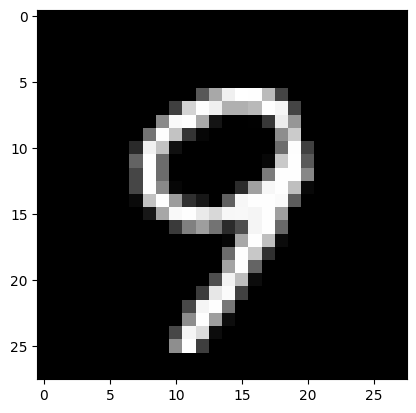

In [5]:
# print some dataset stats and a sample.
import matplotlib.pyplot as plt
import random

print("Training data shape: ", training_data.data.shape)
print("Training labels shape: ", training_data.targets.shape)
print("Test data shape: ", test_data.data.shape)
print("Test labels shape: ", test_data.targets.shape)

# plot a sample
data_point = random.randint(0, len(training_data.data))
plt.imshow(training_data.data[data_point].numpy(), cmap="gray")
print("Label: ", training_data.targets[data_point])

In [9]:
# normalize inputs

# I think alloc problem might be dataset, as changing model size didnt do anything.
# so we'll take only like 5000 samples from the dataset
training_data.data = training_data.data.view(-1, 28*28).float()/255
test_data.data = test_data.data.view(-1, 28*28).float()/255
dataset = {"train_input": training_data.data[:4000], "train_label": training_data.targets[0:4000], "test_input": test_data.data[0:4000], "test_label": test_data.targets[0:4000]}

In [12]:
"""
to train the model, we have to set a train_acc and test_acc function to evaluate the model

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

^ From the hellokan notebook

"""

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label']).float())

results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc))
results['train_acc'][-1], results['test_acc'][-1]

description:   0%|                                                           | 0/20 [00:00<?, ?it/s]


RuntimeError: shape '[4000, 98304]' is invalid for input of size 401408000

In [9]:
# Save the model
import torch
torch.save(model.state_dict(), 'pytorch_mlp_mnist_25epoch.pth')


Training data shape:  torch.Size([60000, 28, 28])
Training labels shape:  torch.Size([60000])
Test data shape:  torch.Size([10000, 28, 28])
Test labels shape:  torch.Size([10000])
Label:  tensor(0)
Prediction:  0


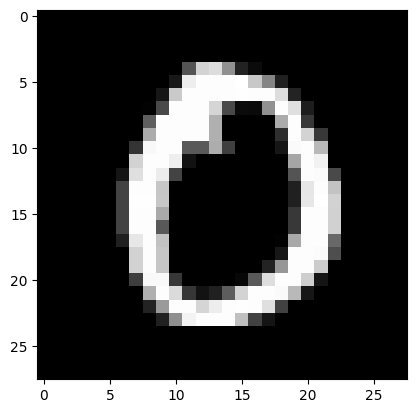

In [36]:
# test the model on a random sample
print("Training data shape: ", training_data.data.shape)
print("Training labels shape: ", training_data.targets.shape)
print("Test data shape: ", test_data.data.shape)
print("Test labels shape: ", test_data.targets.shape)

# plot a sample
data_point = random.randint(0, len(training_data.data))
plt.imshow(training_data.data[data_point].numpy(), cmap="gray")
print("Label: ", training_data.targets[data_point])

with torch.inference_mode():
    result = model.forward(training_data.data[data_point].view(1, -1).to(device, dtype=torch.float32))
    print("Prediction: ", torch.argmax(result).item())